In [53]:
!pip install torch_xla
!pip install -U sympy

In [54]:
import sys
import subprocess
import math
import numpy as np
import pandas as pd
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
import ast

try:
    import esm
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "fair-esm"])
    import esm

In [55]:
# Joseph Group plottin template

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

mpl.rcParams.update({
    "figure.figsize": (3.4, 2.55),
    "font.size": 7,
    "xtick.major.pad": 4,
    "ytick.major.pad": 4,
    "figure.constrained_layout.use": True,
    "figure.dpi": 600,
    "axes.grid": False,
    "legend.fontsize": 7,
    "legend.loc": 'best',
    "font.family": 'sans-serif',
    "font.sans-serif": ["Computer Modern Sans Serif"],
    "axes.labelsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "axes.prop_cycle": mpl.cycler('color', [
        "#323232", "#3b6289", "#4d541d", "#d9ac36", "#e77500", "#ae3832",
        "#c97796", "#72b4c7", "#69853c", "#ffc470", "#bd4f2a", "#761818",
        "#b396bc", "#5b7365", "#b4b990", "#ca976c", "#f37d59", "#9e6b5e",
        "#5D1C34", "#82867f"
    ])
})

In [56]:
# MAIN SCRIPT PARAMETERS
## change these to test combinations, will do grid search down the line

D_MODEL      = 512
ENC_LAYERS   = 3
CO_LAYERS    = 2
NHEAD        = 8
DROPOUT      = 0.1
LR           = 1e-4
WEIGHT_DECAY = 1e-2
EPOCHS       = 150
PATIENCE     = 30
BATCH_SIZE   = 16

# loss knobs
MU_SMOOTH_SIGMA_BINS = 0.5
W_MU     = 1.0
W_SIGMA  = 3.0
HUBER_DELTA = 1e-3

TARGET_N_POLICY = "mode"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [57]:
def _resample_1d(arr: np.ndarray, target_N: int) -> np.ndarray:
    old_N = len(arr)
    if old_N == target_N:
        return arr.astype(np.float32, copy=True)
    x_old = np.linspace(0.0, 1.0, num=old_N, dtype=np.float32)
    x_new = np.linspace(0.0, 1.0, num=target_N, dtype=np.float32)
    return np.interp(x_new, x_old, arr.astype(np.float32)).astype(np.float32)

def _normalize_safe(v: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    s = float(np.sum(v))
    if not np.isfinite(s) or s <= eps:
        return np.full_like(v, 1.0 / len(v))
    return v / s

In [58]:
def prepare_targets_and_bins(df: pd.DataFrame):
    def mu_norm(pair):
        a = np.asarray(pair[0], np.float32); b = np.asarray(pair[1], np.float32)
        s = float(a.sum() + b.sum()) or 1.0
        return [a/s, b/s]
    def sigma_abs(pair):
        a = np.asarray(pair[0], np.float32); b = np.asarray(pair[1], np.float32)
        return [np.clip(a,0,None), np.clip(b,0,None)]

    df = df.copy()
    df['mu_norm']   = df['radial_avg'].apply(mu_norm)
    df['sigma_abs'] = df['radial_std'].apply(sigma_abs)
    df['N_bins']    = df['mu_norm'].apply(lambda m: len(m[0]))

    bad = df[df['N_bins'] != df['sigma_abs'].apply(lambda s: len(s[0]))]
    if len(bad) > 0:
        raise ValueError(f"Rows with μ/σ bin mismatch: indices {bad.index.tolist()}")

    lens = df['N_bins'].tolist()
    if isinstance(TARGET_N_POLICY, int):
        target_N = int(TARGET_N_POLICY)
    elif TARGET_N_POLICY == "max":
        target_N = int(max(lens))
    else: # mode (most common )
        c = Counter(lens); target_N = int(c.most_common(1)[0][0])
    return df, target_N

In [59]:
class SeqPairRadialDataset(Dataset):
    def __init__(self, df: pd.DataFrame, target_N: int):
        self.df = df.reset_index(drop=True)
        self.Nt = int(target_N)
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        seq1, seq2 = row['seq1'], row['seq2']
        mu1, mu2 = row['mu_norm'][0], row['mu_norm'][1]
        sg1, sg2 = row['sigma_abs'][0], row['sigma_abs'][1]

        mu1_r = _normalize_safe(_resample_1d(np.asarray(mu1, np.float32), self.Nt))
        mu2_r = _normalize_safe(_resample_1d(np.asarray(mu2, np.float32), self.Nt))
        sg1_r = np.clip(_resample_1d(np.asarray(sg1, np.float32), self.Nt), 0.0, None)
        sg2_r = np.clip(_resample_1d(np.asarray(sg2, np.float32), self.Nt), 0.0, None)

        y_avg = torch.tensor(np.stack([mu1_r, mu2_r], axis=0), dtype=torch.float32)
        y_std = torch.tensor(np.stack([sg1_r, sg2_r], axis=0), dtype=torch.float32)
        return seq1, seq2, y_avg, y_std, i

In [60]:
# ESM
esm_model, esm_alphabet = esm.pretrained.esm2_t12_35M_UR50D()
esm_model = esm_model.eval().to(DEVICE)
for p in esm_model.parameters():
    p.requires_grad_(False)
batch_converter = esm_alphabet.get_batch_converter()
PAD_IDX = esm_alphabet.padding_idx
ESM_H = esm_model.embed_dim

@torch.no_grad()
def collate_esm(batch):
    names1 = [f"s1_{i}" for *_, i in batch]
    names2 = [f"s2_{i}" for *_, i in batch]
    seqs1  = [s1 for s1,_,_,_,_ in batch]
    seqs2  = [s2 for _,s2,_,_,_ in batch]

    _, _, toks1 = batch_converter(list(zip(names1, seqs1)))
    _, _, toks2 = batch_converter(list(zip(names2, seqs2)))
    toks1 = toks1.to(DEVICE); toks2 = toks2.to(DEVICE)

    out1 = esm_model(toks1, repr_layers=[esm_model.num_layers], return_contacts=False)
    out2 = esm_model(toks2, repr_layers=[esm_model.num_layers], return_contacts=False)
    rep1_full = out1["representations"][esm_model.num_layers]
    rep2_full = out2["representations"][esm_model.num_layers]

    rep1 = rep1_full[:, 1:-1, :]
    rep2 = rep2_full[:, 1:-1, :]
    padmask1 = (toks1[:, 1:-1] == PAD_IDX)
    padmask2 = (toks2[:, 1:-1] == PAD_IDX)

    y_avg = torch.stack([y for _,_,y,_,_ in batch], dim=0)
    y_std = torch.stack([y for _,_,_,y,_ in batch], dim=0)
    gidx  = torch.tensor([i for *_, i in batch], dtype=torch.long)
    return rep1, padmask1, rep2, padmask2, y_avg, y_std, gidx

# Architecture
class SequenceEncoder(nn.Module):
    def __init__(self, esm_h, d_model=512, nhead=8, layers=3, dropout=0.1):
        super().__init__()
        self.proj = nn.Linear(esm_h, d_model)
        enc = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                         dim_feedforward=4*d_model,
                                         dropout=dropout, batch_first=True,
                                         activation='gelu')
        self.encoder = nn.TransformerEncoder(enc, num_layers=layers)
    def forward(self, reps, key_padding_mask):
        x = self.proj(reps)
        return self.encoder(x, src_key_padding_mask=key_padding_mask)

class CoAttentionBlock(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super().__init__()
        self.attn12 = nn.MultiheadAttention(d_model, nhead, batch_first=True, dropout=dropout)
        self.attn21 = nn.MultiheadAttention(d_model, nhead, batch_first=True, dropout=dropout)
        self.norm1a = nn.LayerNorm(d_model); self.norm1b = nn.LayerNorm(d_model)
        self.norm2a = nn.LayerNorm(d_model); self.norm2b = nn.LayerNorm(d_model)
        self.ffn1 = nn.Sequential(nn.Linear(d_model, 4*d_model), nn.GELU(), nn.Dropout(dropout), nn.Linear(4*d_model, d_model))
        self.ffn2 = nn.Sequential(nn.Linear(d_model, 4*d_model), nn.GELU(), nn.Dropout(dropout), nn.Linear(4*d_model, d_model))
        self.drop = nn.Dropout(dropout)
    def forward(self, h1, m1, h2, m2):
        z1, _ = self.attn12(h1, h2, h2, key_padding_mask=m2)
        h1 = self.norm1a(h1 + self.drop(z1))
        h1 = self.norm1b(h1 + self.drop(self.ffn1(h1)))
        z2, _ = self.attn21(h2, h1, h1, key_padding_mask=m1)
        h2 = self.norm2a(h2 + self.drop(z2))
        h2 = self.norm2b(h2 + self.drop(self.ffn2(h2)))
        return h1, h2

class AttnPool(nn.Module):
    def __init__(self, d_model, nhead=8):
        super().__init__()
        self.q = nn.Parameter(torch.randn(1, 1, d_model))
        self.attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)
    def forward(self, x, key_padding_mask):
        q = self.q.expand(x.size(0), -1, -1)
        z, _ = self.attn(q, x, x, key_padding_mask=key_padding_mask)
        return z.squeeze(1)

class BiXAttnCondensate(nn.Module):
    def __init__(self, esm_h, d_model, nhead, enc_layers, co_layers, N_bins, dropout=0.1):
        super().__init__()
        self.N = int(N_bins)
        self.enc1 = SequenceEncoder(esm_h, d_model, nhead, enc_layers, dropout)
        self.enc2 = SequenceEncoder(esm_h, d_model, nhead, enc_layers, dropout)
        self.co_blocks = nn.ModuleList([CoAttentionBlock(d_model, nhead, dropout) for _ in range(co_layers)])
        self.pool1 = AttnPool(d_model, nhead)
        self.pool2 = AttnPool(d_model, nhead)
        self.fuse = nn.Sequential(
            nn.Linear(4*d_model, 2*d_model), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(2*d_model, d_model),   nn.GELU(),
        )
        self.mu_head    = nn.Linear(d_model, 2*self.N)
        self.sigma_head = nn.Linear(d_model, 2*self.N)
    def forward(self, rep1, padmask1, rep2, padmask2):
        h1 = self.enc1(rep1, padmask1)
        h2 = self.enc2(rep2, padmask2)
        for block in self.co_blocks:
            h1, h2 = block(h1, padmask1, h2, padmask2)
        z1 = self.pool1(h1, key_padding_mask=padmask1)
        z2 = self.pool2(h2, key_padding_mask=padmask2)
        z  = torch.cat([z1, z2, z1*z2, torch.abs(z1-z2)], dim=-1)
        z  = self.fuse(z)
        mu_logits = self.mu_head(z).view(-1, 2, self.N)
        sg_raw    = self.sigma_head(z).view(-1, 2, self.N)
        mu_hat = F.softmax(mu_logits, dim=-1)
        sg_hat = F.softplus(sg_raw)
        return mu_hat, sg_hat

In [61]:
# loss functions
def gaussian_kernel_1d(size: int, sigma_bins: float) -> np.ndarray:
    if size % 2 == 0: size += 1
    x = np.arange(size) - size // 2
    k = np.exp(-0.5 * (x / sigma_bins) ** 2)
    k /= k.sum()
    return k.astype(np.float32)

def smooth_labels_gaussian(y: torch.Tensor, sigma_bins: float) -> torch.Tensor:
    if sigma_bins <= 0: return y
    B, C, N = y.shape
    k_np = gaussian_kernel_1d(size=max(3, int(6 * sigma_bins) | 1), sigma_bins=sigma_bins)
    k = torch.tensor(k_np, device=y.device, dtype=y.dtype).view(1, 1, -1)
    x = y.reshape(B * C, 1, N)
    pad = k.shape[-1] // 2
    x = F.pad(x, (pad, pad), mode="reflect")
    x = F.conv1d(x, k)
    x = x / (x.sum(dim=-1, keepdim=True) + 1e-12)
    return x.view(B, C, N)

def cdf_emd2_loss(p: torch.Tensor, q: torch.Tensor) -> torch.Tensor:
    p_cdf = torch.cumsum(p, dim=-1)
    q_cdf = torch.cumsum(q, dim=-1)
    return F.mse_loss(p_cdf, q_cdf)

def huber(x, y, delta=1e-3):
    return F.huber_loss(x, y, delta=delta, reduction='mean')

In [62]:
df = pd.read_csv("data.txt", converters={"radial_avg": ast.literal_eval, "radial_std": ast.literal_eval})
df, TARGET_N = prepare_targets_and_bins(df)

full_ds = SeqPairRadialDataset(df, target_N=TARGET_N)
n_tr = int(0.8*len(full_ds)); n_val = len(full_ds) - n_tr
train_ds, val_ds = random_split(full_ds, [n_tr, n_val], generator=torch.Generator())
val_indices = val_ds.indices

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_esm)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_esm)

# scale sigma
with torch.no_grad():
    sigma_vals = []
    for _, _, y_avg, y_std, _ in DataLoader(val_ds, batch_size=64, shuffle=False):
        s = y_std.numpy().reshape(-1)
        s = s[s > 0]
        if s.size: sigma_vals.append(s)
    sigma_scale = float(np.median(np.concatenate(sigma_vals))) if len(sigma_vals) else 1e-3

model = BiXAttnCondensate(
    esm_h=ESM_H, d_model=D_MODEL, nhead=NHEAD,
    enc_layers=ENC_LAYERS, co_layers=CO_LAYERS,
    N_bins=TARGET_N, dropout=DROPOUT
).to(DEVICE)

def train_model(model, train_loader, val_loader, epochs=EPOCHS, patience=PATIENCE):
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.StepLR(opt, step_size=80, gamma=0.5)
    best_val, no_improve = float('inf'), 0
    hist = {'train': [], 'val': []}
    for ep in range(1, epochs+1):
        model.train(); tr_sum = 0.0
        for rep1, pm1, rep2, pm2, y_avg, y_std, _ in train_loader:
            y_avg = y_avg.to(DEVICE); y_std = y_std.to(DEVICE)
            y_avg_smooth = smooth_labels_gaussian(y_avg, MU_SMOOTH_SIGMA_BINS) if MU_SMOOTH_SIGMA_BINS > 0 else y_avg
            mu_hat, sg_hat = model(rep1, pm1, rep2, pm2)
            loss_mu = cdf_emd2_loss(mu_hat, y_avg_smooth)
            y_sigma_log = torch.log1p(y_std / sigma_scale)
            p_sigma_log = torch.log1p(sg_hat / sigma_scale)
            loss_sigma = huber(p_sigma_log, y_sigma_log, delta=HUBER_DELTA)
            loss = W_MU * loss_mu + W_SIGMA * loss_sigma
            opt.zero_grad(); loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tr_sum += loss.item()

        model.eval(); va_sum = 0.0
        with torch.no_grad():
            for rep1, pm1, rep2, pm2, y_avg, y_std, _ in val_loader:
                y_avg = y_avg.to(DEVICE); y_std = y_std.to(DEVICE)
                y_avg_smooth = smooth_labels_gaussian(y_avg, MU_SMOOTH_SIGMA_BINS) if MU_SMOOTH_SIGMA_BINS > 0 else y_avg
                mu_hat, sg_hat = model(rep1, pm1, rep2, pm2)
                loss_mu = cdf_emd2_loss(mu_hat, y_avg_smooth)
                y_sigma_log = torch.log1p(y_std / sigma_scale)
                p_sigma_log = torch.log1p(sg_hat / sigma_scale)
                loss_sigma = huber(p_sigma_log, y_sigma_log, delta=HUBER_DELTA)
                va_sum += (W_MU * loss_mu + W_SIGMA * loss_sigma).item()

        tr = tr_sum / max(1, len(train_loader))
        va = va_sum / max(1, len(val_loader))
        hist['train'].append(tr); hist['val'].append(va)
        sched.step()
        print(f"Epoch {ep:03d},  train {tr:.4e},  val {va:.4e}")

        if va < best_val - 1e-6:
            best_val, no_improve = va, 0
            torch.save(model.state_dict(), "best_esm2_biXattn_emd_logsigma.pth")
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stop after {patience} epochs.")
                break
    return hist

# train model
history = train_model(model, train_loader, val_loader)

Epoch 001,  train 8.3140e-02,  val 4.3513e-02
Epoch 002,  train 4.3144e-02,  val 4.0242e-02
Epoch 003,  train 4.0808e-02,  val 3.8473e-02
Epoch 004,  train 3.9462e-02,  val 3.6943e-02
Epoch 005,  train 3.7114e-02,  val 3.4356e-02
Epoch 006,  train 3.2633e-02,  val 2.5593e-02
Epoch 007,  train 2.3368e-02,  val 2.0471e-02
Epoch 008,  train 2.1972e-02,  val 2.0256e-02
Epoch 009,  train 2.1710e-02,  val 2.1186e-02
Epoch 010,  train 2.2205e-02,  val 1.8629e-02
Epoch 011,  train 2.0545e-02,  val 1.7772e-02
Epoch 012,  train 1.9741e-02,  val 1.7635e-02
Epoch 013,  train 1.9327e-02,  val 1.8334e-02
Epoch 014,  train 1.8809e-02,  val 1.7825e-02
Epoch 015,  train 1.9643e-02,  val 1.7191e-02
Epoch 016,  train 1.8668e-02,  val 1.7308e-02
Epoch 017,  train 1.8854e-02,  val 1.7219e-02
Epoch 018,  train 1.8842e-02,  val 1.7247e-02
Epoch 019,  train 1.8485e-02,  val 1.7181e-02
Epoch 020,  train 1.8460e-02,  val 1.8259e-02
Epoch 021,  train 1.7525e-02,  val 1.6448e-02
Epoch 022,  train 1.5345e-02,  val

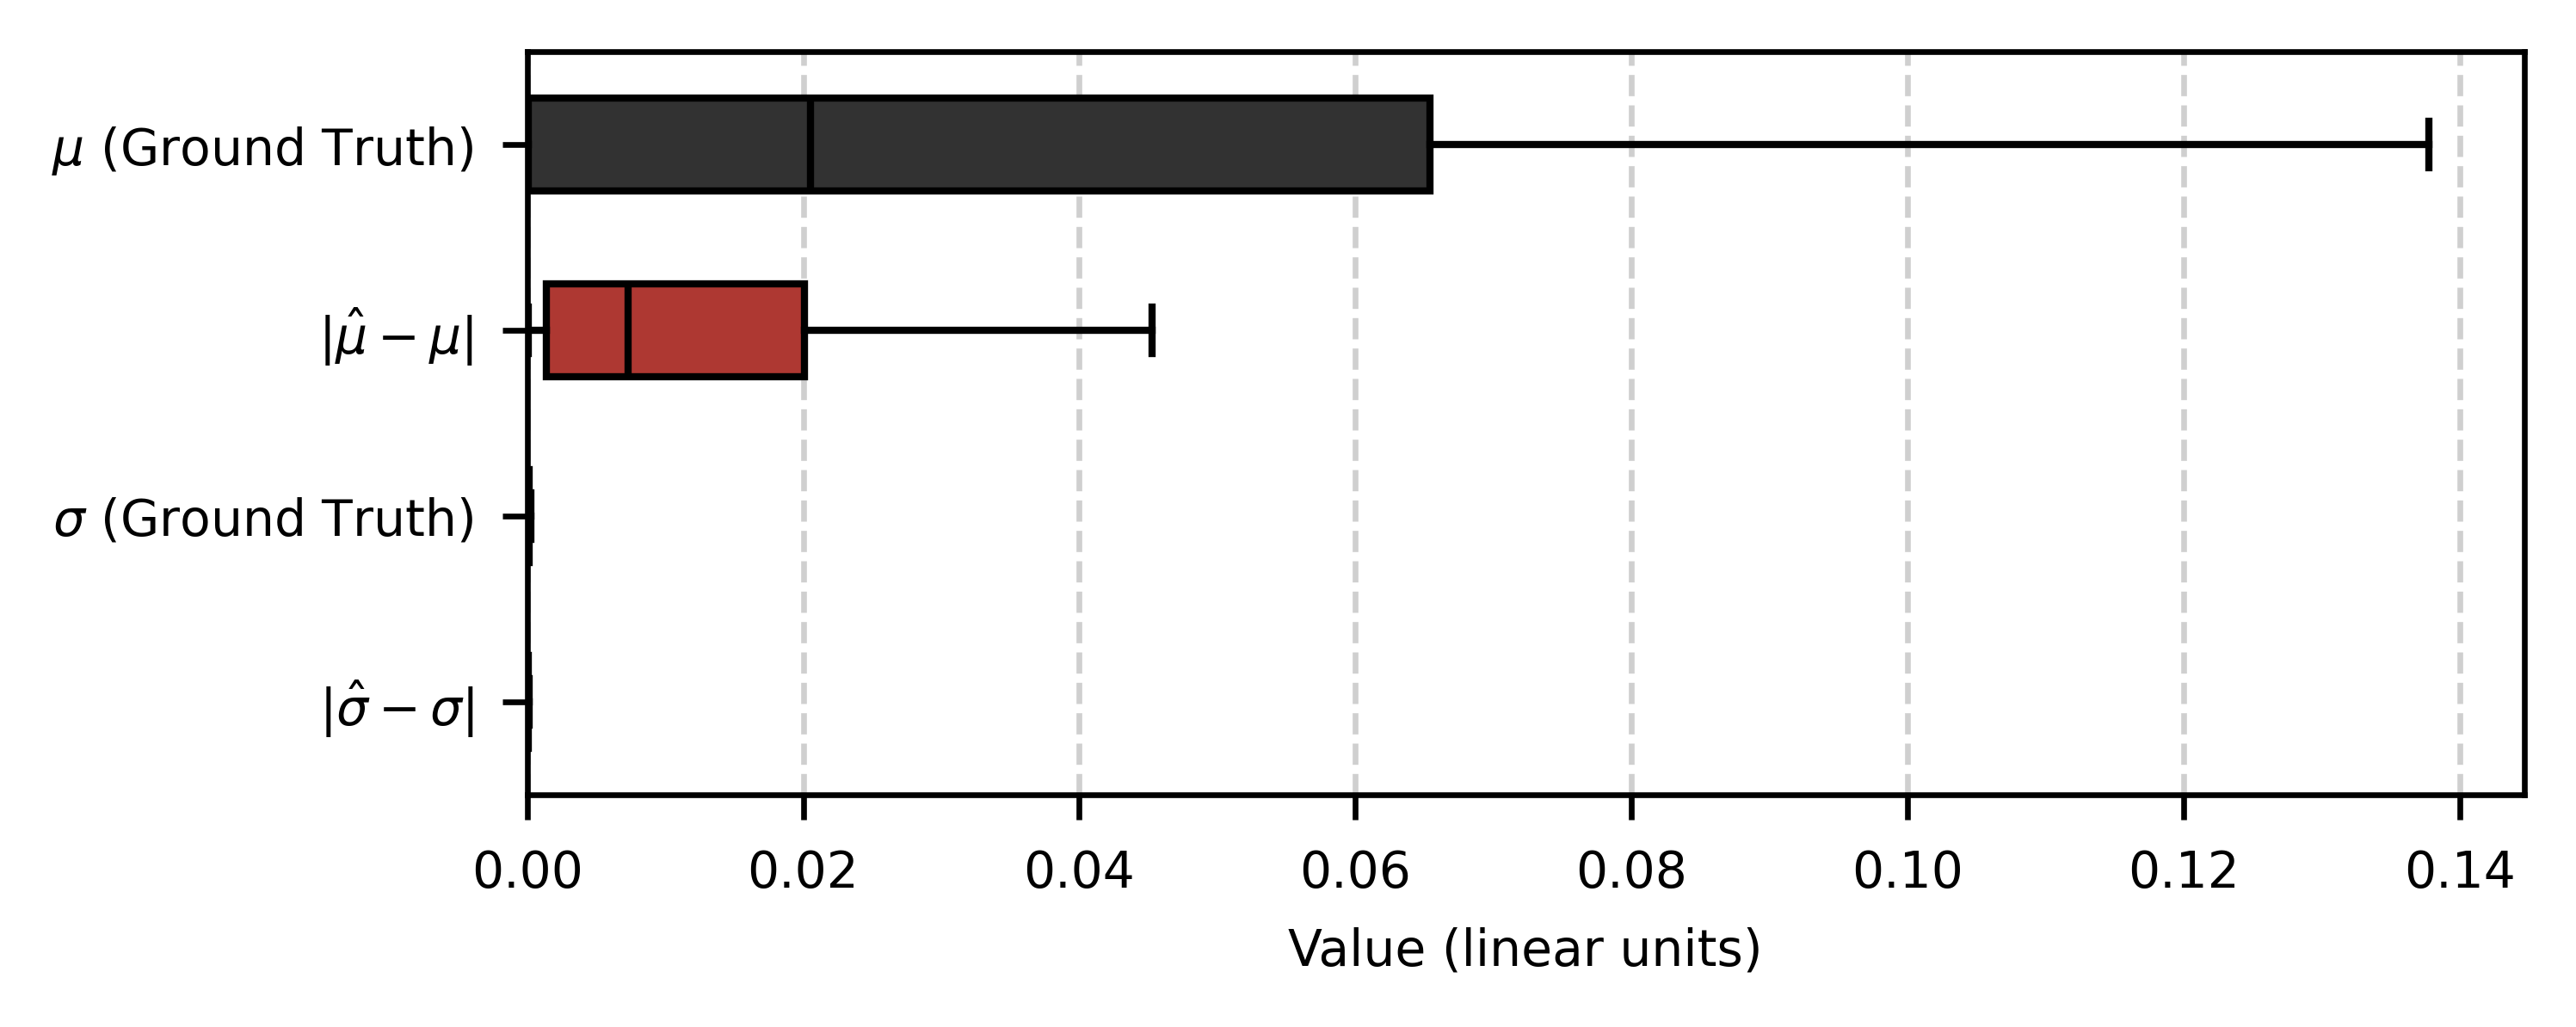

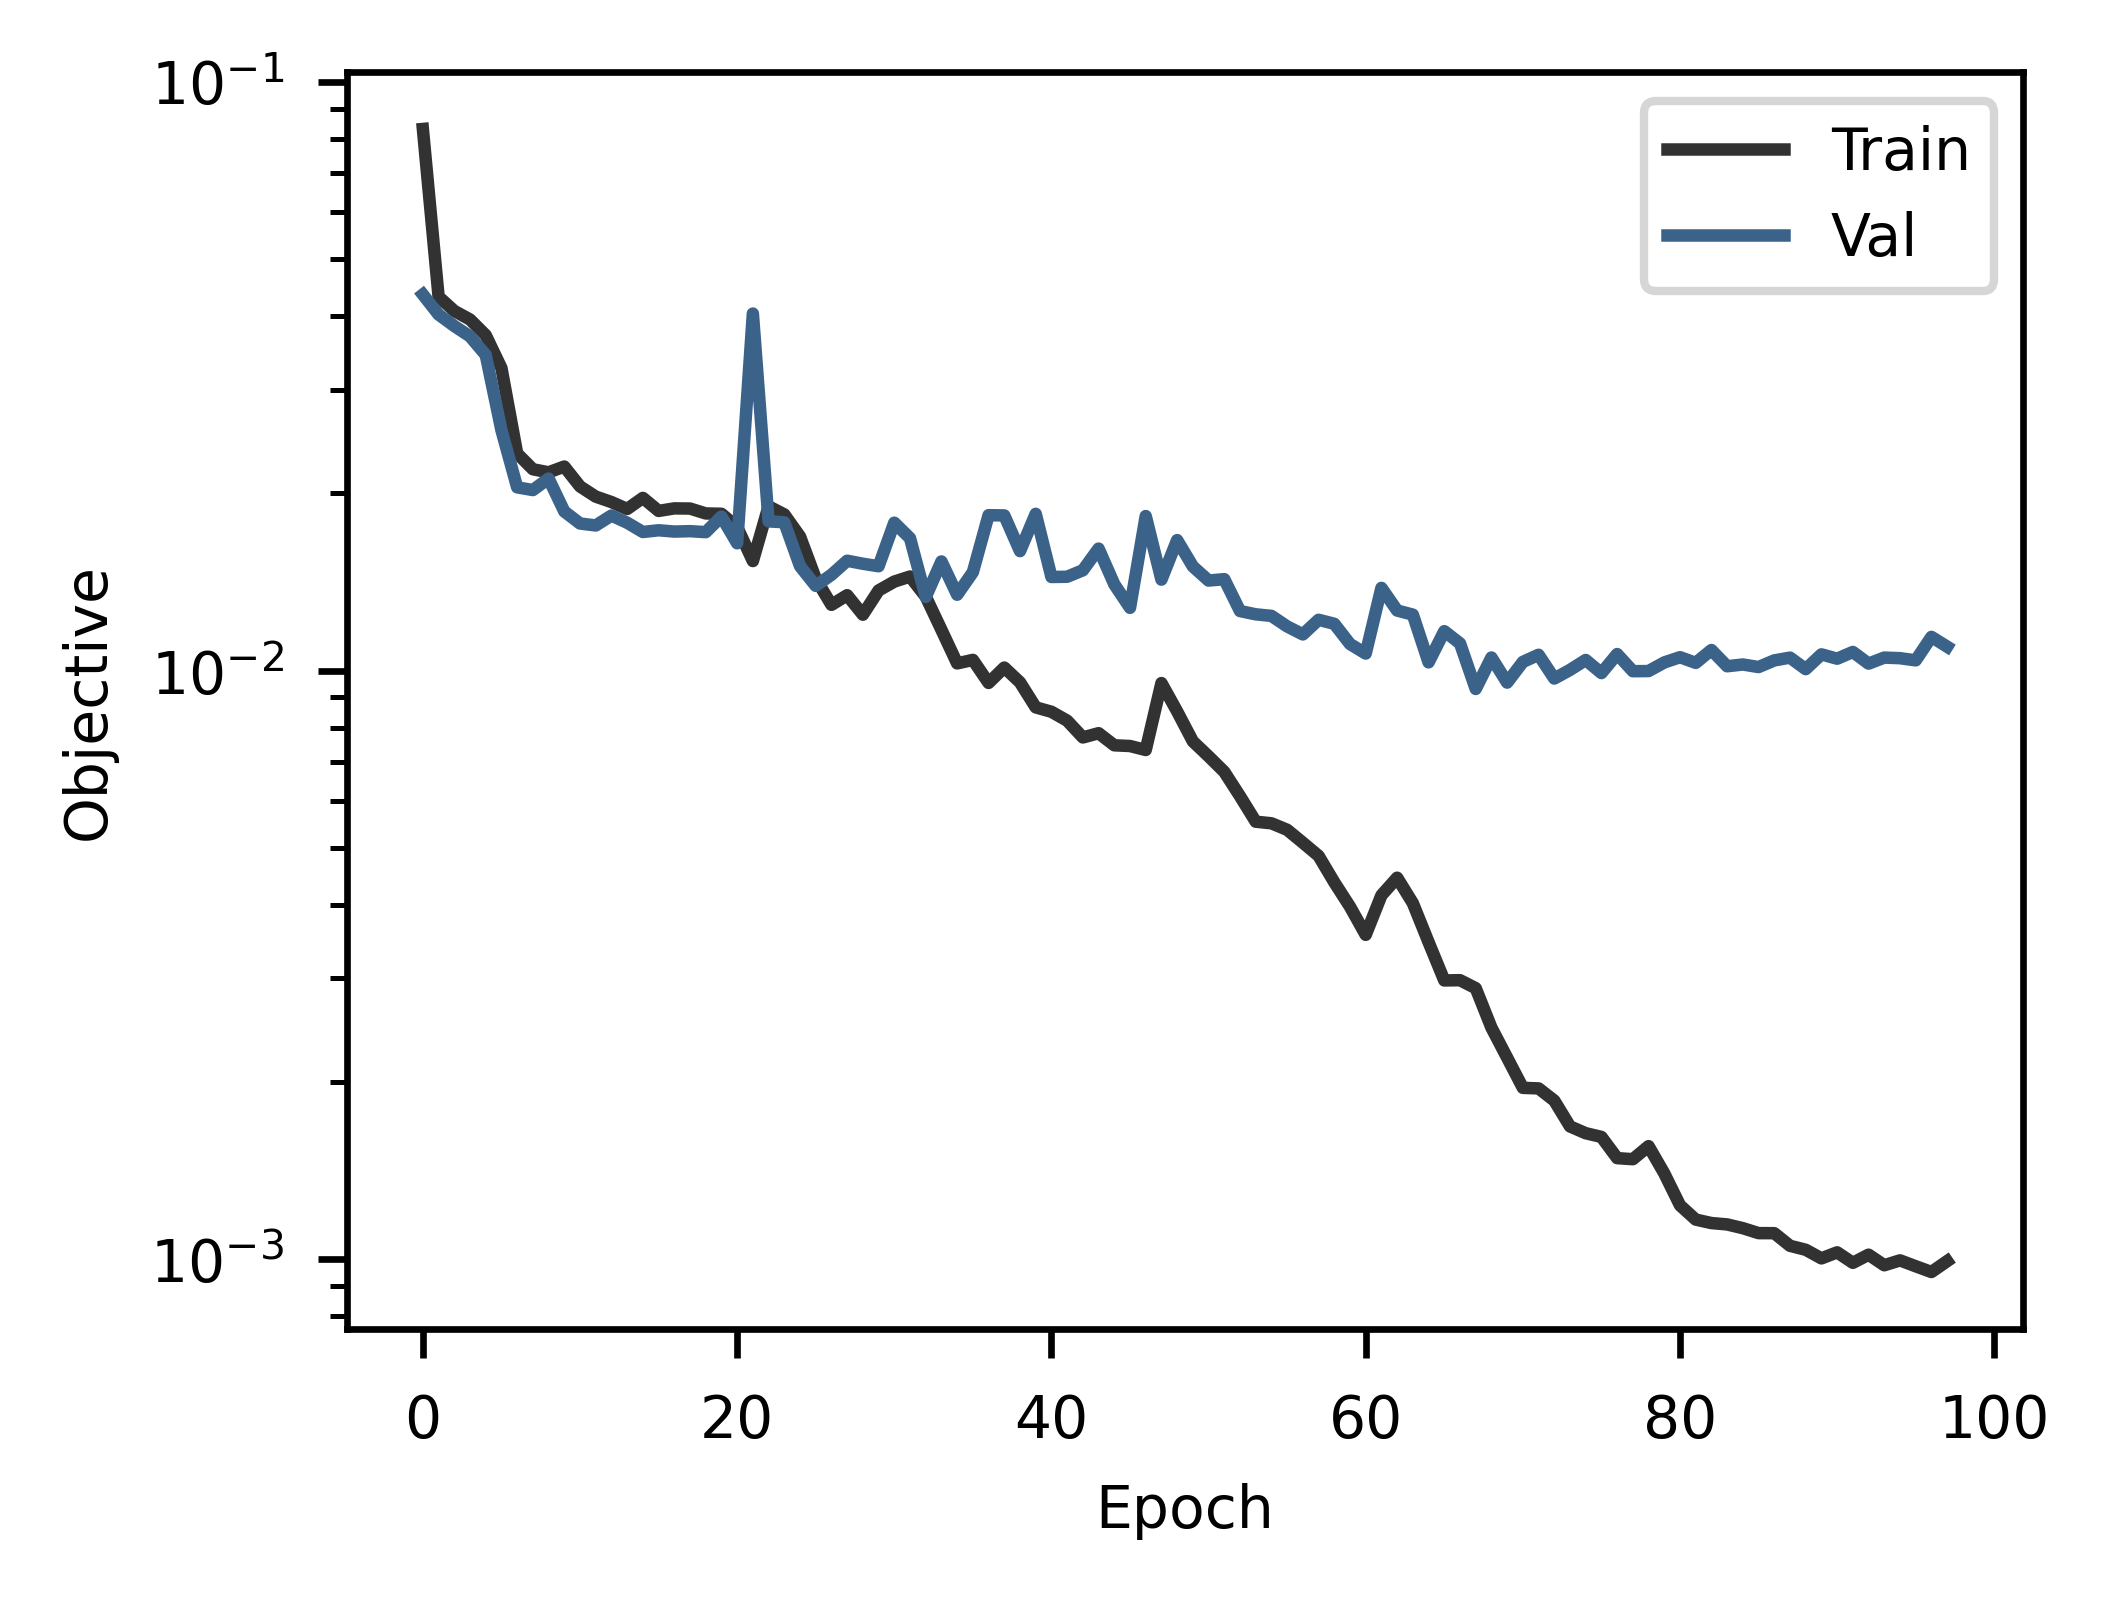

R^2 (mu, linear):    0.79955
R^2 (sigma, linear): 0.42348


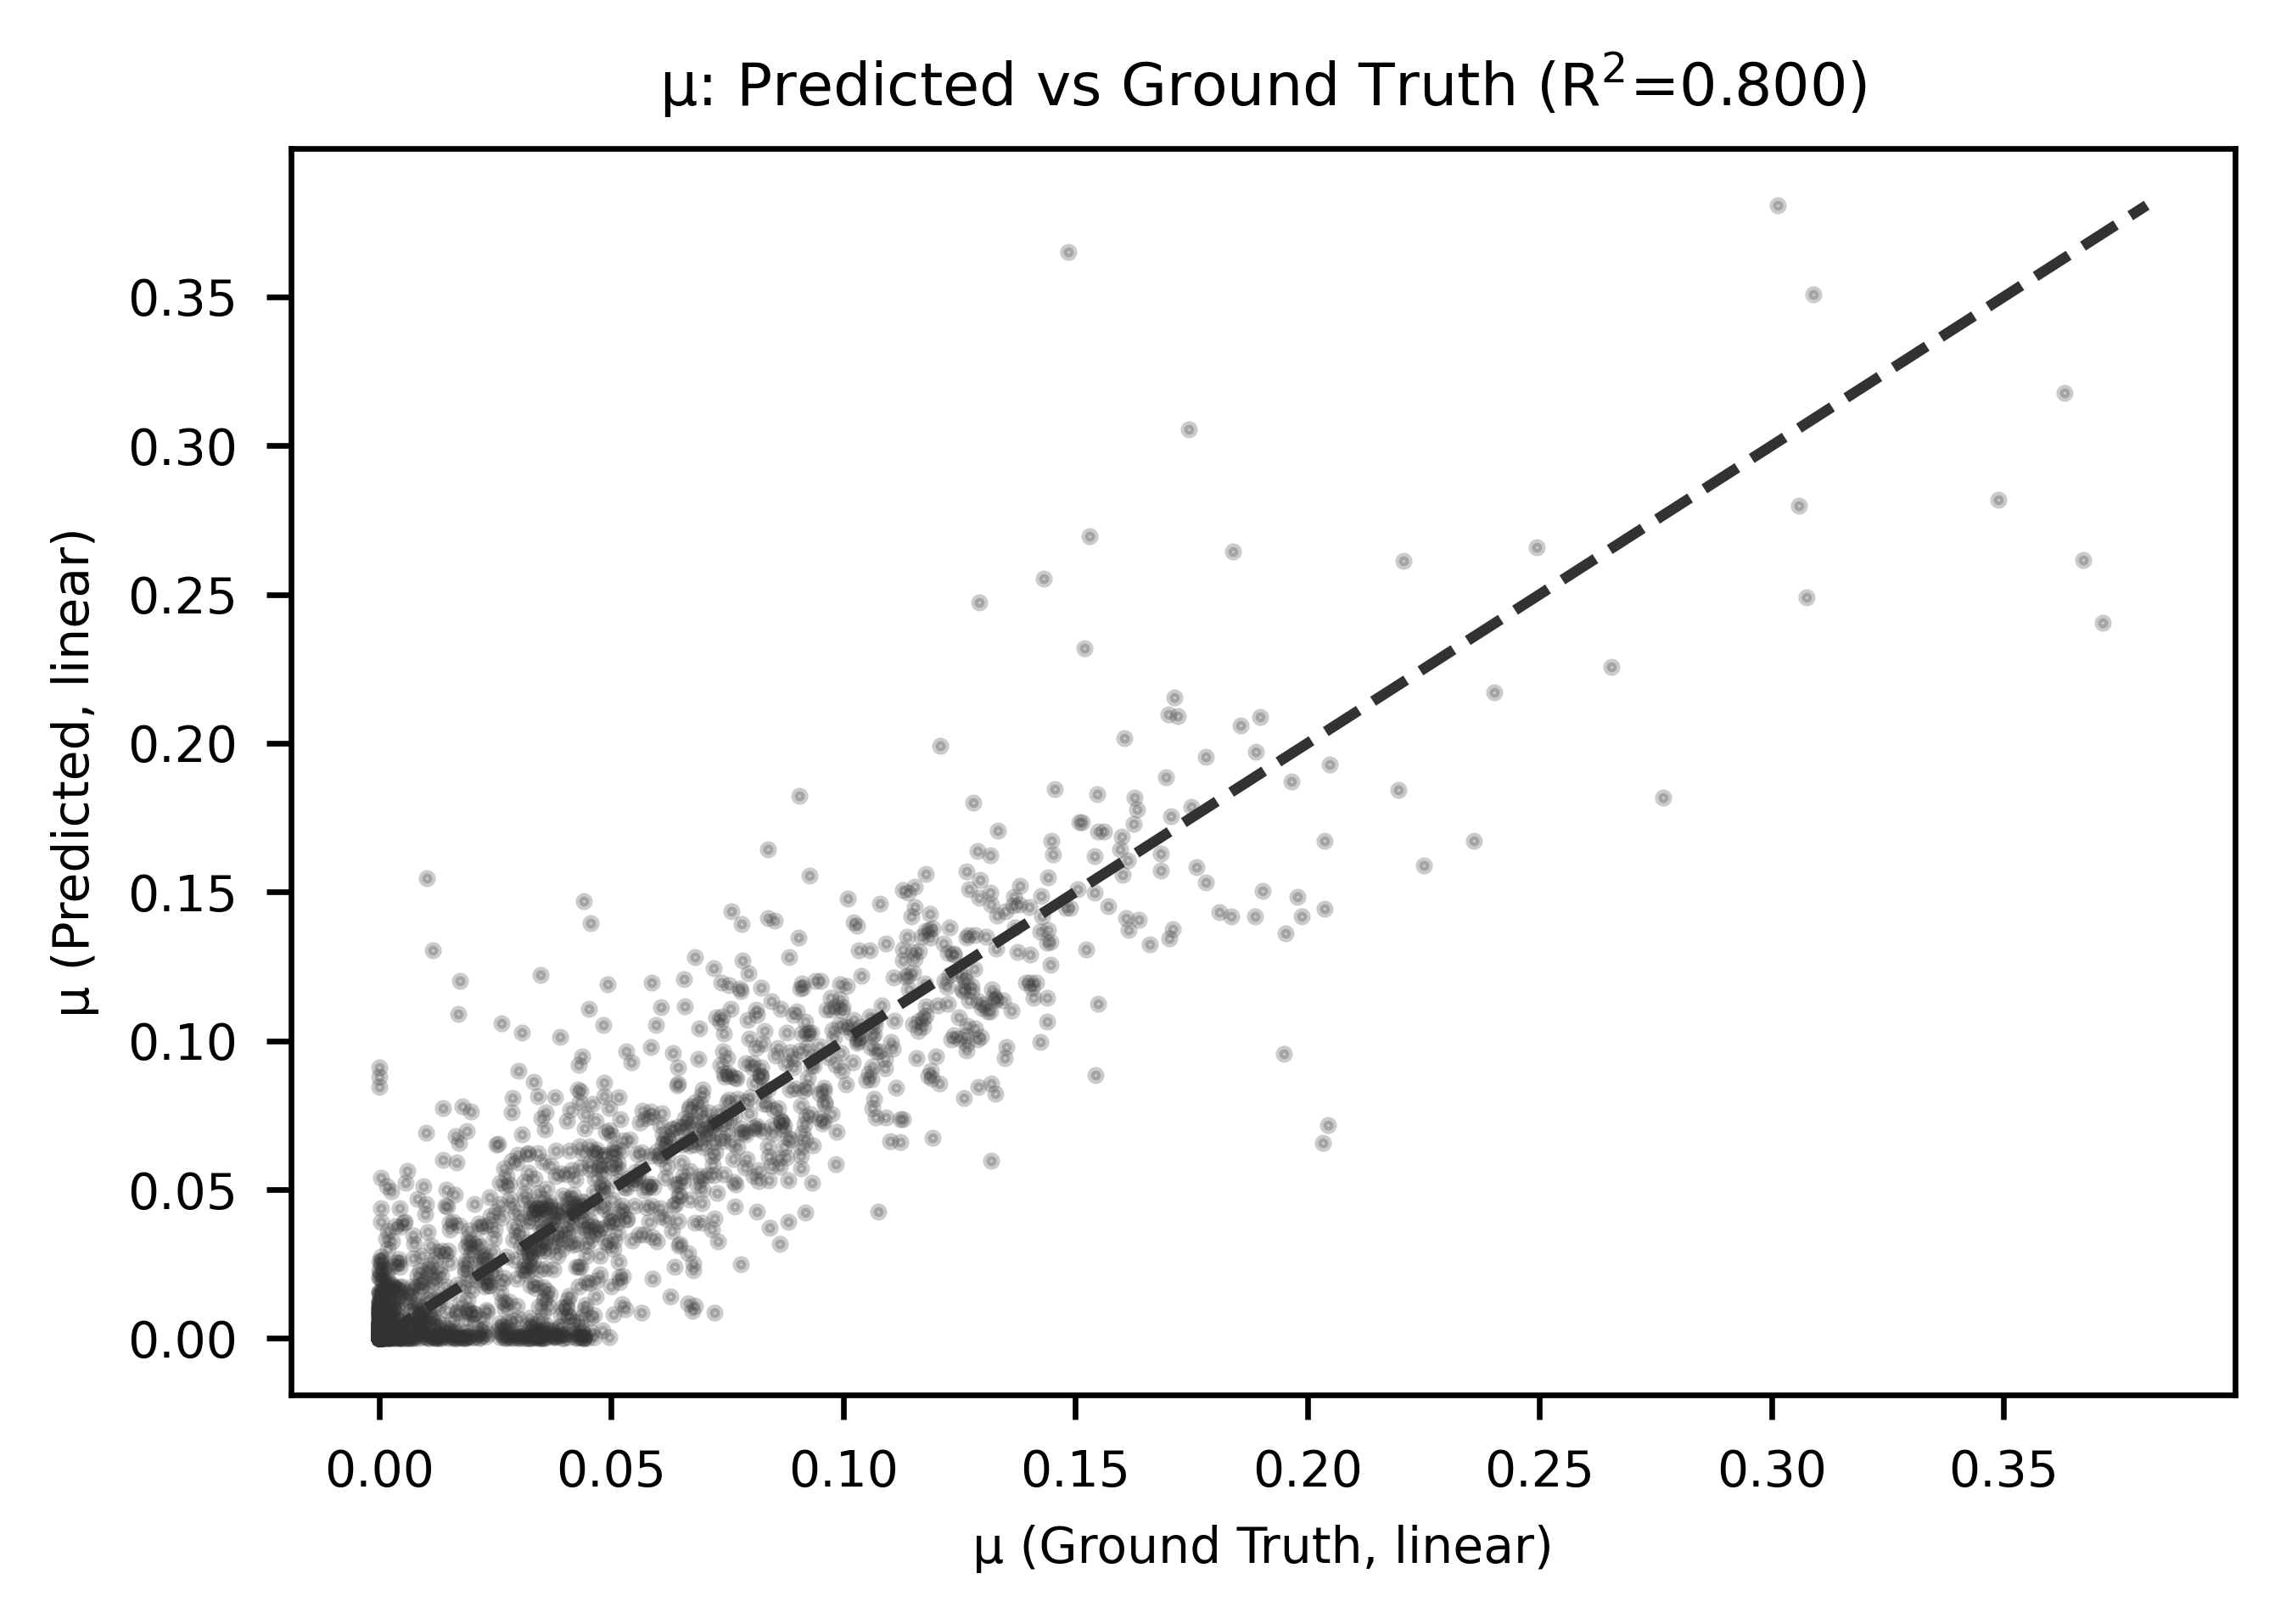

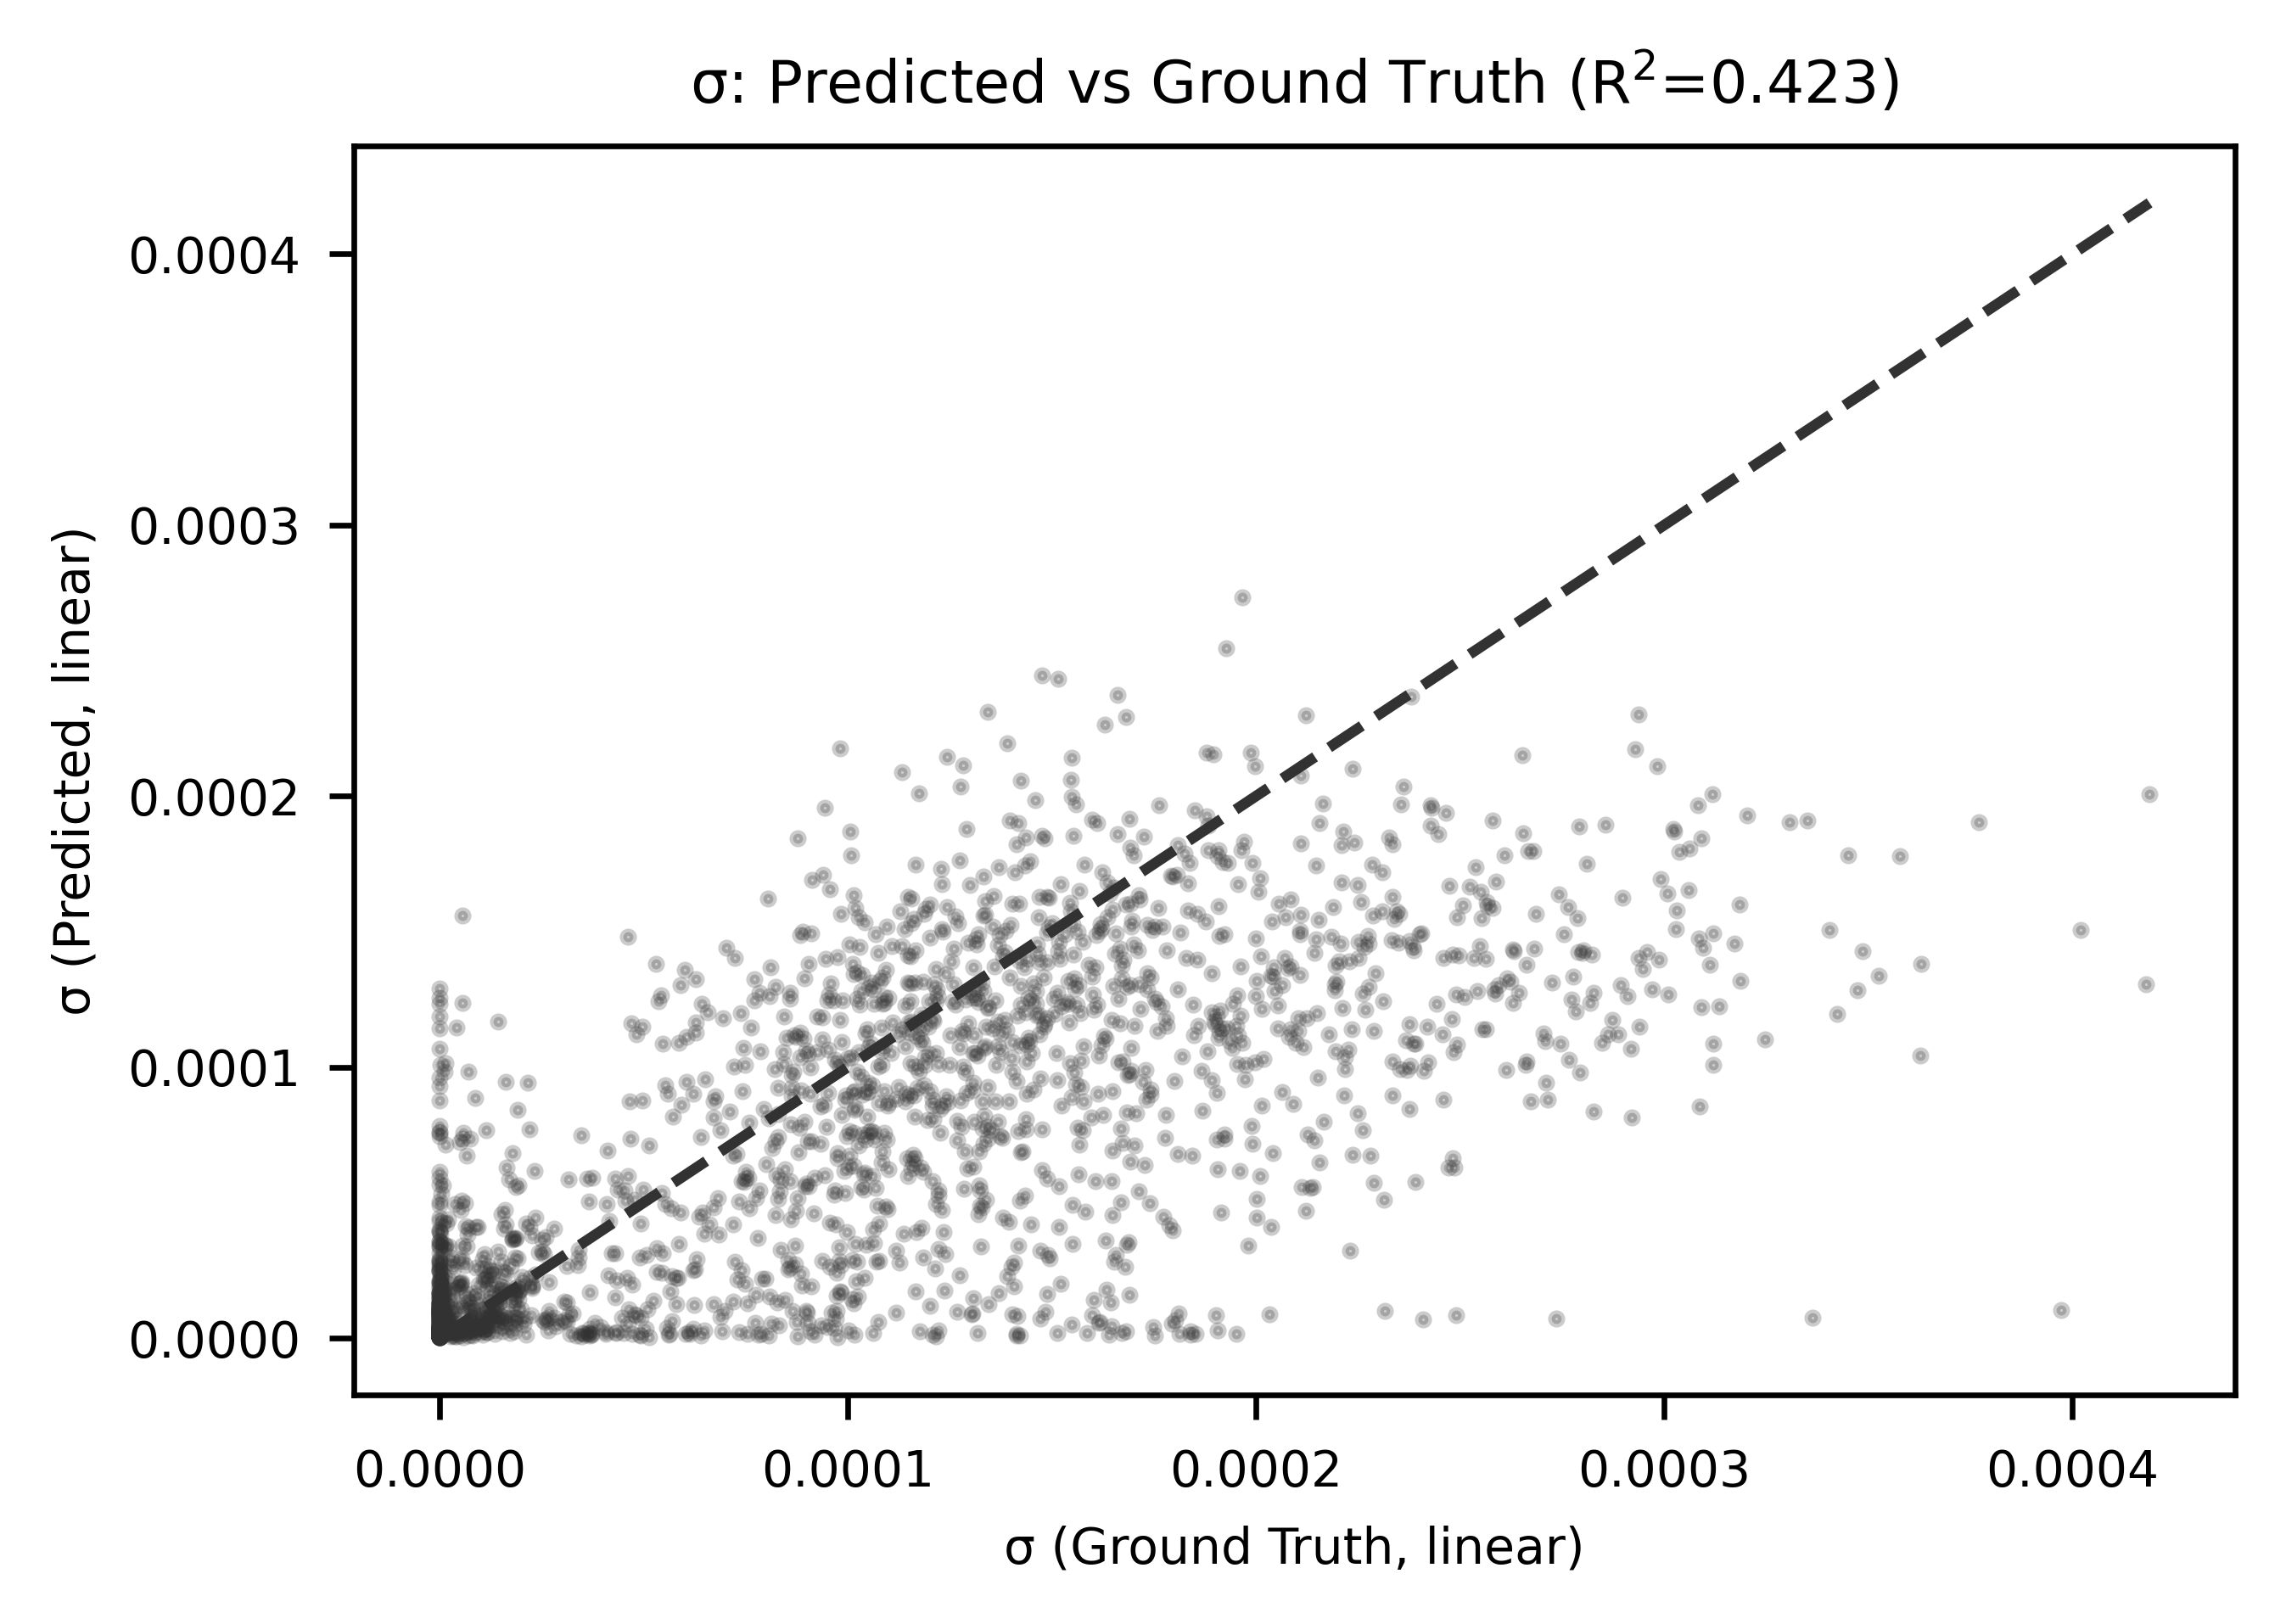

In [65]:
all_mu_gt, all_mu_pred = [], []
all_sigma_gt_lin, all_sigma_pred_lin = [], []
all_mu_diff, all_sigma_diff_lin = [], []

# Load the best model weights
model.load_state_dict(torch.load("best_esm2_biXattn_emd_logsigma.pth"))
model.eval()
with torch.no_grad():
    for rep1, pm1, rep2, pm2, y_avg, y_std, _ in val_loader:
        mu_hat, sg_hat = model(rep1, pm1, rep2, pm2)
        mu_hat_np = mu_hat.cpu().numpy()
        sg_hat_np = sg_hat.cpu().numpy()
        y_avg_np  = y_avg.numpy()
        y_std_np  = y_std.numpy()
        all_mu_gt.append(y_avg_np.reshape(-1))
        all_mu_pred.append(mu_hat_np.reshape(-1))
        all_sigma_gt_lin.append(y_std_np.reshape(-1))
        all_sigma_pred_lin.append(sg_hat_np.reshape(-1))
        all_mu_diff.append(np.abs(mu_hat_np - y_avg_np).reshape(-1))
        all_sigma_diff_lin.append(np.abs(sg_hat_np - y_std_np).reshape(-1))

all_mu_gt           = np.concatenate(all_mu_gt)
all_mu_pred         = np.concatenate(all_mu_pred)
all_sigma_gt_lin    = np.concatenate(all_sigma_gt_lin)
all_sigma_pred_lin  = np.concatenate(all_sigma_pred_lin)
all_mu_diff         = np.concatenate(all_mu_diff)
all_sigma_diff_lin  = np.concatenate(all_sigma_diff_lin)

# Mu and Sigma boxplots
data = [all_mu_gt, all_mu_diff, all_sigma_gt_lin, all_sigma_diff_lin]
positions = [4, 3, 2, 1]
labels = [r'$\mu$ (Ground Truth)', r'$|\hat{\mu} - \mu|$',
          r'$\sigma$ (Ground Truth)', r'$|\hat{\sigma} - \sigma|$']
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
box_colors = [default_colors[0], default_colors[5], default_colors[0], default_colors[4]]

fig, ax = plt.subplots(figsize=(5, 2))
for y, pos, color in zip(data, positions, box_colors):
    ax.boxplot(y, vert=False, positions=[pos], showfliers=False, widths=0.5, whis=[5, 95],
               patch_artist=True, boxprops=dict(facecolor=color, edgecolor='black'),
               medianprops=dict(color='black'))
ax.set_yticks(positions); ax.set_yticklabels(labels)
ax.set_xlabel('Value (linear units)'); ax.grid(True, axis='x', linestyle='--', alpha=0.6)
ax.set_xlim(left=0); plt.tight_layout(); plt.show()

# Loss plots
plt.figure()
plt.plot(history['train'], label='Train'); plt.plot(history['val'], label='Val')
plt.yscale('log'); plt.xlabel('Epoch'); plt.ylabel('Objective'); plt.legend(); plt.show()

# R^2 plots
def r2_score_np(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = y_true.astype(np.float64)
    y_pred = y_pred.astype(np.float64)
    sse = np.sum((y_true - y_pred) ** 2)
    sst = np.sum((y_true - y_true.mean()) ** 2)
    return float(1.0 - sse / sst) if sst > 0 else np.nan

R2_mu_lin    = r2_score_np(all_mu_gt,        all_mu_pred)
R2_sigma_lin = r2_score_np(all_sigma_gt_lin, all_sigma_pred_lin)
print(f"R^2 (mu, linear):    {R2_mu_lin:.5f}")
print(f"R^2 (sigma, linear): {R2_sigma_lin:.5f}")

def scatter_with_r2(y_true, y_pred, title, xlabel, ylabel):
    n = y_true.shape[0]
    max_points = 50000
    if n > max_points:
        idx = np.random.choice(n, size=max_points, replace=False)
        yt, yp = y_true[idx], y_pred[idx]
    else:
        yt, yp = y_true, y_pred
    lo = float(min(yt.min(), yp.min()))
    hi = float(max(yt.max(), yp.max()))
    plt.figure(figsize=(4.5, 3.2))
    plt.scatter(yt, yp, s=2, alpha=0.25)
    plt.plot([lo, hi], [lo, hi], linestyle='--')
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    plt.tight_layout(); plt.show()

scatter_with_r2(
    all_mu_gt, all_mu_pred,
    title=f"μ: Predicted vs Ground Truth (R$^2$={R2_mu_lin:.3f})",
    xlabel="μ (Ground Truth, linear)", ylabel="μ (Predicted, linear)"
)
scatter_with_r2(
    all_sigma_gt_lin, all_sigma_pred_lin,
    title=f"σ: Predicted vs Ground Truth (R$^2$={R2_sigma_lin:.3f})",
    xlabel="σ (Ground Truth, linear)", ylabel="σ (Predicted, linear)"
)

Log sigma R^2 plot

R^2 (sigma, log1p-space): 0.53867


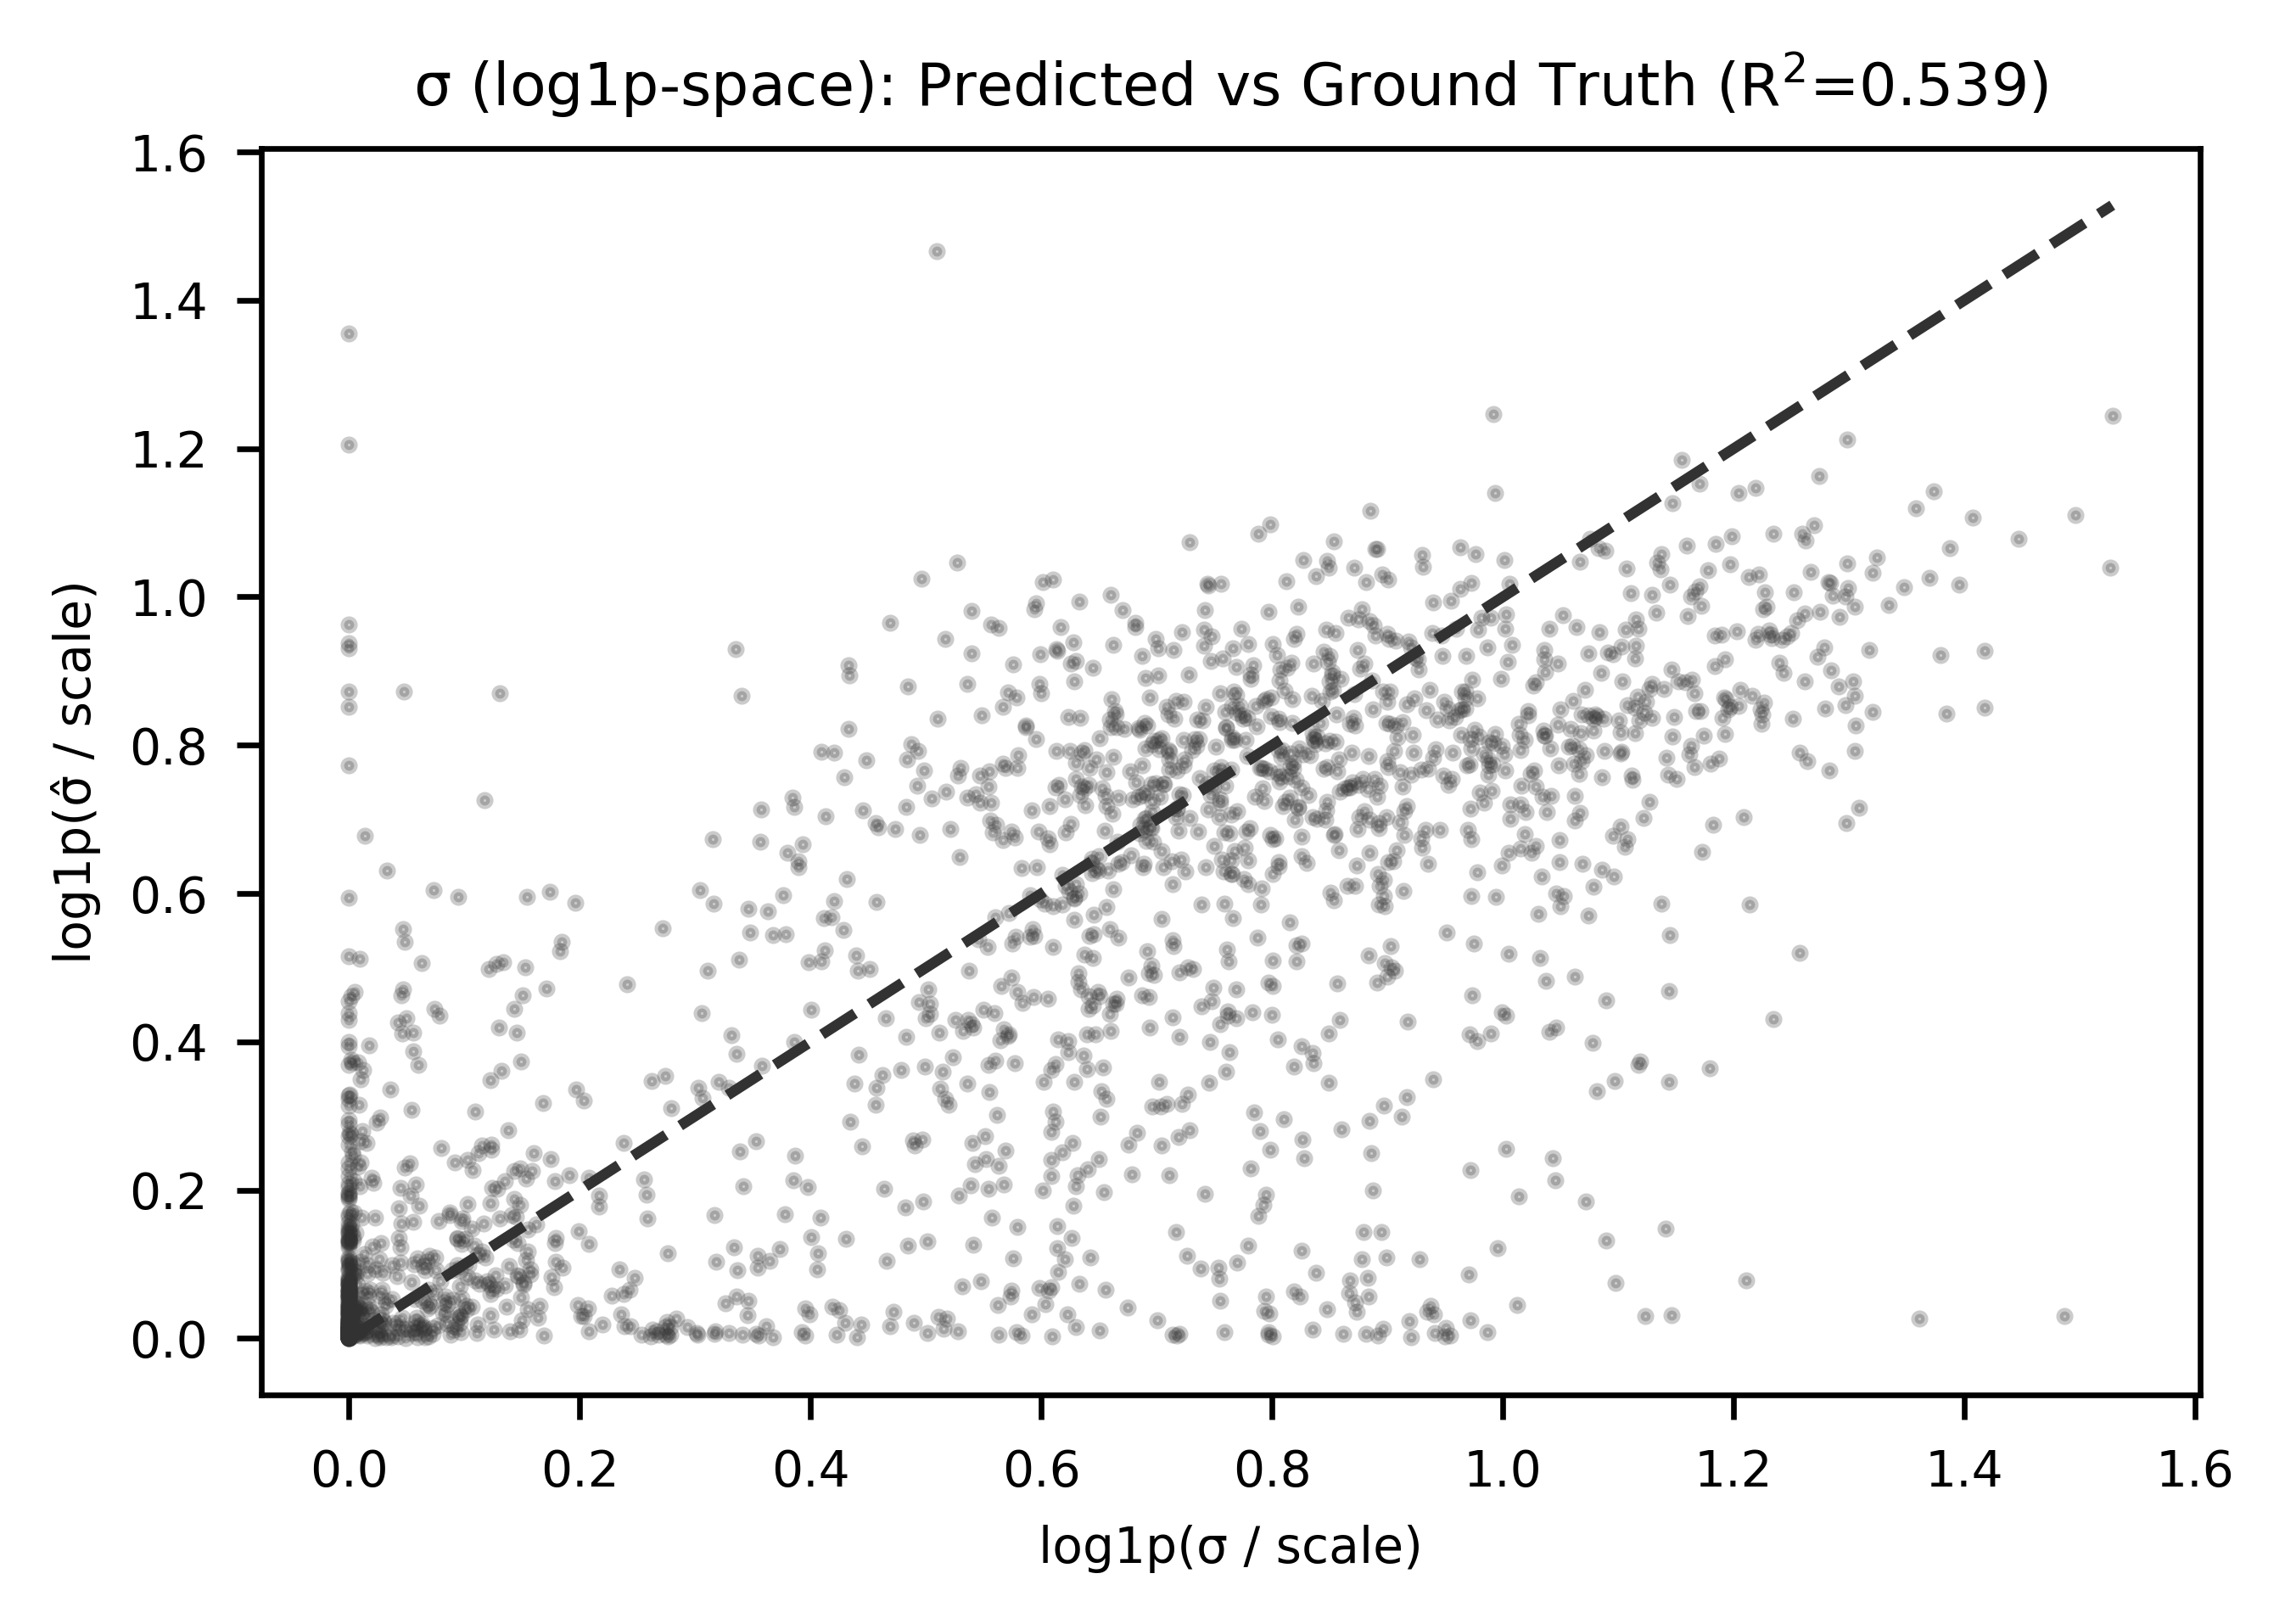

In [64]:
eps_scale = max(1e-12, sigma_scale)
gt_log   = np.log1p(all_sigma_gt_lin / eps_scale)
pred_log = np.log1p(all_sigma_pred_lin / eps_scale)
R2_sigma_log = r2_score_np(gt_log, pred_log)
print(f"R^2 (sigma, log1p-space): {R2_sigma_log:.5f}")
scatter_with_r2(
    gt_log, pred_log,
    title=f"σ (log1p-space): Predicted vs Ground Truth (R$^2$={R2_sigma_log:.3f})",
    xlabel="log1p(σ / scale)", ylabel="log1p(σ̂ / scale)"
)